# Listening to the audio
This code enables you to listen to a sample sine wave audio.

In [2]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy
# import torch
from sklearn.decomposition import IncrementalPCA
from collections import defaultdict

In [3]:
SAMPLE_RATE = 22050
sr = SAMPLE_RATE

In [5]:
# take only a portion of the data for exploration
traindata = pd.read_csv("train.csv",nrows=500)

In [6]:
traindata.shape

(500, 88201)

In [8]:
ipd.Audio(traindata[2][:-1], rate=SAMPLE_RATE)

In [14]:
T = 4.0    # seconds
t = np.linspace(0, T, int(T*SAMPLE_RATE), endpoint=False) # time variable
freq = 640
signal = np.sin(2*np.pi*freq*t)
ipd.Audio(signal, rate=SAMPLE_RATE)

# Creating spectrograms
Spectrograms provide a 2D feature space to analyze signals in the joint time-frequency domain.

This code generates the spectrogram files for use with the CNN example. It makes files for non-noised data!

In [9]:
# Just some re-shaping and dimension finding
#N = 1
#print("N:",N)
#train = signal[np.newaxis,:]
print("Train shape",traindata.shape)
N_train = traindata.shape[0]
NUM_SAMPLES = traindata.shape[1]-1

X_train = traindata[:,:-1]
y_train = traindata[:,-1]
y_train = y_train.reshape(N_train,1)

('Train shape', (500L, 88201L))


In [10]:
# JUST SOME FOURIER TRANSFORM PARAMETERS
BINS_OCTAVE = 12*2
N_OCTAVES = 7
NUM_BINS = BINS_OCTAVE * N_OCTAVES

In [11]:
# Given a wav time series, makes a mel spectrogram
# which is a short-time fourier transform with
# frequencies on the mel (log) scale.
def mel_spec(y):
    Q = librosa.cqt(y=y, sr=SAMPLE_RATE, bins_per_octave=BINS_OCTAVE,n_bins=NUM_BINS)
    Q_db = librosa.amplitude_to_db(librosa.magphase(Q)[0],ref=np.max)
    return Q_db

In [12]:
# This means that the spectrograms are 168 rows (frequencies)
# By 173 columns (time frames)
#song = X_train[0]
song = traindata[0][:-1]
test_spec = mel_spec(song)
print(test_spec.shape)
FEATS = test_spec.shape[0]
FRAMES = test_spec.shape[1]

(168L, 173L)


In [14]:
tmp_train = np.zeros((N_train,FEATS,FRAMES))
for i in range(N_train):
    tmp_train[i,:,:] = mel_spec(X_train[i])
#np.save('Data/xtrain_spec', tmp_train)

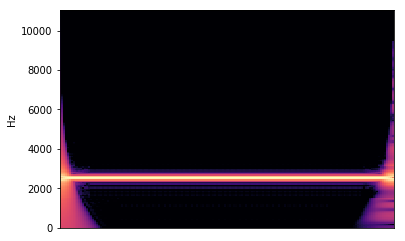

In [27]:
#draw a variety of spectograms from different classes:
librosa.display.specshow(tmp_train[0], y_axis='hz')

In [29]:
# collect samples belonging to different classes 
examples=defaultdict(list)
for i, c in enumerate(traindata[:,-1]):
    examples[int(c)].append(i)
    
for k, v in examples.items():
    print(k, len(v))


0 33
8 10
5 11
4 6
9 18
2 9
7 12
3 1


0.0


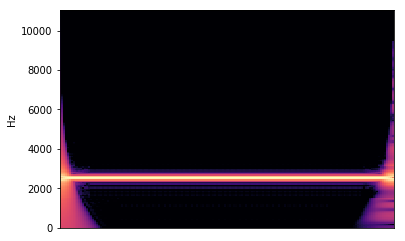

In [34]:
i=examples[0][4]
song = traindata[i][:-1]
test_spec = mel_spec(song)
librosa.display.specshow(test_spec, y_axis='hz')
print(traindata[i,-1])

In [339]:
test_spec.shape, song.shape

((168, 173), (88200,))

2.0


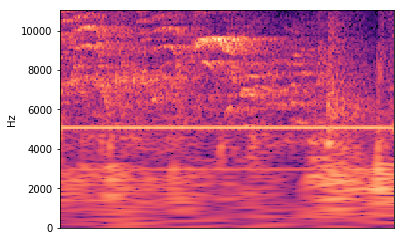

In [35]:
i=examples[2][3]
song = traindata[i][:-1]
test_spec = mel_spec(song)
librosa.display.specshow(test_spec[:-1], y_axis='hz')
print(traindata[i,-1])

3.0


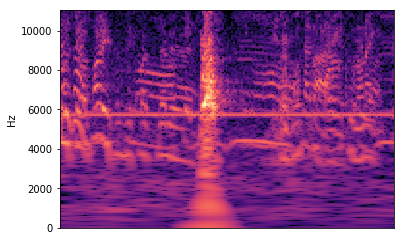

In [37]:
i=examples[3][0]
song = traindata[i][:-1]
test_spec = mel_spec(song)
librosa.display.specshow(test_spec[:-1], y_axis='hz')
print(traindata[i,-1])

8.0


C:\Users\ASUS\Anaconda2\envs\NewTrial\lib\site-packages\librosa\core\spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


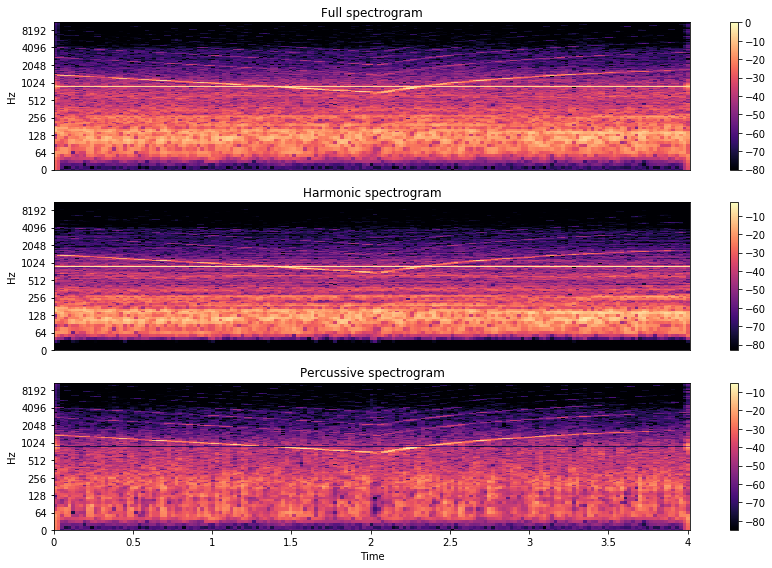

In [39]:
# split spectogram into percussive and harmonic components and plot the results:

i=examples[8][0]
song = traindata[i][:-1]
print(traindata[i,-1])
D = librosa.stft(song)
D_harmonic, D_percussive = librosa.decompose.hpss(D)
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_harmonic, ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(D_percussive, ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

8.0


C:\Users\ASUS\Anaconda2\envs\NewTrial\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 100)

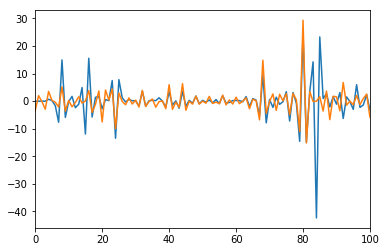

In [48]:
# Sum the separate harmonic and percussive parts of the spectogram along the time axis: 
# plot a sample separation to see how the distribution over frequencies look like: 
i=examples[8][0]
song = traindata[i][:-1]
test_spec = mel_spec(song)
#librosa.display.specshow(test_spec[:-1], y_axis='hz')
print(traindata[i,-1])
D = librosa.stft(song)
D_harmonic, D_percussive = librosa.decompose.hpss(D)
harmonicsum = np.sum(D_harmonic, axis=1)
percussivesum = np.sum(D_percussive, axis=1)
plt.plot(harmonicsum)
plt.plot(percussivesum)
plt.xlim(0,100)


In [47]:
# Compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(song))

In [323]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [324]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

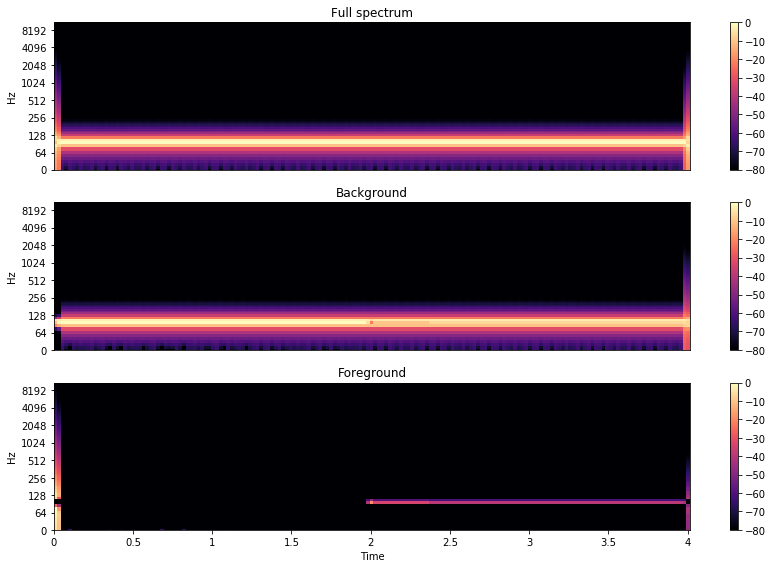

In [325]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [210]:
#function to extract features from a single track using LibROSA library functions
#input: single audio track
#output: feature vector of 203 elements

def extract_features(X):
    D = librosa.stft(X)
    stft = np.abs(librosa.stft(X))
    chroma = np.mean(librosa.feature.chroma_stft(y=X, S=stft, sr=SAMPLE_RATE).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=SAMPLE_RATE).T,axis=0)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=SAMPLE_RATE, n_mfcc=40).T,axis=0)
    centroid = np.mean(librosa.feature.spectral_centroid(y=X, S=stft, sr=SAMPLE_RATE).T,axis=0)
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, S=stft, sr=SAMPLE_RATE).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=X, S=stft, sr=SAMPLE_RATE).T,axis=0)
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=X, S=stft).T,axis=0)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=X, S=stft, sr=SAMPLE_RATE).T,axis=0)
    poly_features = np.mean(librosa.feature.poly_features(y=X, S=stft, sr=SAMPLE_RATE).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=SAMPLE_RATE).T,axis=0)
    D_harmonic, D_percussive = librosa.decompose.hpss(D)
    harmonicsum = np.sum(D_harmonic, axis=1)
    percussivesum = np.sum(D_percussive, axis=1)
    harmonicmax = max(harmonicsum)
    harmonicmin = min(harmonicsum)
    percussivemax = max(percussivesum)
    percussivemin = min(percussivesum)
    return np.hstack((chroma,mel,mfccs,centroid,bandwidth,contrast,spectral_flatness,rolloff,poly_features,tonnetz,harmonicmax,harmonicmin,percussivemax,percussivemin))


In [211]:
# Read the training data in chunks and extract features from each example in each chunk 
# keep track of the class of each example

X_feat = np.empty((0,203))
Y_train = np.empty((0,1))
N = 253
t = 0

for chunck_df in pd.read_csv('train.csv', header=None, chunksize=N):
    print(t)
    train = chunck_df.values
    N_train = train.shape[0]
    NUM_SAMPLES = train.shape[1]-1

    X_train = train[:,:-1]
    y_train = train[:,-1]
    y_train = y_train.reshape(N_train,1)
    
    Y_train = np.vstack((Y_train,y_train))
    
    for i in range(0,N_train):
        a = extract_features(X_train[i])
        X_feat = np.vstack((X_feat,a))  
    t = t + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [236]:
# Read the test data in chunks and extract features from each example in each chunk 
# keep track of the ID of each example

X_feattest = np.empty((0,203))
ID_test = np.empty((0,1))
N = 100
t = 0
for chunck_df in pd.read_csv('test.csv',header=None, chunksize=N):
    test = chunck_df.values
    N_test = test.shape[0]
    X_test = test[:,1:]
    y_test = test[:,0]
    y_test = y_test.reshape(N_test,1)
    if t == 0:
        print(y_test)
    ID_test = np.vstack((ID_test,y_test))
    
    for i in range(0,N_test):
        a = extract_features(X_test[i])
        X_feattest = np.vstack((X_feattest,a))
    print(t)
    t = t+1

[[ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]
 [ 6.]
 [ 7.]
 [ 8.]
 [ 9.]
 [10.]
 [11.]
 [12.]
 [13.]
 [14.]
 [15.]
 [16.]
 [17.]
 [18.]
 [19.]
 [20.]
 [21.]
 [22.]
 [23.]
 [24.]
 [25.]
 [26.]
 [27.]
 [28.]
 [29.]
 [30.]
 [31.]
 [32.]
 [33.]
 [34.]
 [35.]
 [36.]
 [37.]
 [38.]
 [39.]
 [40.]
 [41.]
 [42.]
 [43.]
 [44.]
 [45.]
 [46.]
 [47.]
 [48.]
 [49.]
 [50.]
 [51.]
 [52.]
 [53.]
 [54.]
 [55.]
 [56.]
 [57.]
 [58.]
 [59.]
 [60.]
 [61.]
 [62.]
 [63.]
 [64.]
 [65.]
 [66.]
 [67.]
 [68.]
 [69.]
 [70.]
 [71.]
 [72.]
 [73.]
 [74.]
 [75.]
 [76.]
 [77.]
 [78.]
 [79.]
 [80.]
 [81.]
 [82.]
 [83.]
 [84.]
 [85.]
 [86.]
 [87.]
 [88.]
 [89.]
 [90.]
 [91.]
 [92.]
 [93.]
 [94.]
 [95.]
 [96.]
 [97.]
 [98.]
 [99.]]
0
1
2
3
4
5
6
7
8
9


In [238]:
# write csv files with the data in case of a crash so that one doesn't have to repeat the long and
# computationally expensive feature extraction process
np.savetxt("xfeat.csv", X_feat, delimiter=",")
np.savetxt("ytrain.csv", Y_train, delimiter=",")

np.savetxt("xfeattest.csv", X_feattest, delimiter=",")
np.savetxt("IDtest.csv", ID_test, delimiter=",")

In [212]:
# download relevant sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score

In [217]:
#separate training and validation data
Xtr, Xval, ytr, yval = train_test_split(X_feat, Y_train, test_size=0.25, random_state=42)

In [219]:
#check shapes 
print(Xtr.shape,Xval.shape,ytr.shape,yval.shape)

((4743L, 203L), (1582L, 203L), (4743L, 1L), (1582L, 1L))


In [239]:
# Train a Logistic Regression
LR = LogisticRegression()
LR.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [240]:
# Create predictions and see training and validation accuracy
y_pred = LR.predict(Xval)
B = np.reshape(yval,y_pred.shape) == y_pred 
accval = 1.*sum(B)/len(B)
print("validation accuracy", accval)
y_pred = LR.predict(Xtr)
B = np.reshape(ytr,y_pred.shape) == y_pred 
acctrain = 1.*sum(B)/len(B)
print("train accuracy", acctrain)

('validation accuracy', 0.9854614412136536)
('train accuracy', 0.9951507484714316)


In [209]:
# write predictions to a CSV along with their IDs; 
IDs = np.reshape(ID_test,p1.shape)
PRED1 = np.transpose(np.vstack((IDs,p1)))
PRED1 = PRED1.astype(int)
np.savetxt("p1.csv", PRED1, delimiter=",")

In [241]:
# Train a Support Vector Machine
sv = SVC()
sv.fit(Xtr, ytr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [242]:
# Create predictions and see training and validation accuracy
y_pred = sv.predict(Xval)
B = np.reshape(yval,y_pred.shape) == y_pred 
accval = 1.*sum(B)/len(B)
print("validation accuracy", accval)
y_pred = sv.predict(Xtr)
B = np.reshape(ytr,y_pred.shape) == y_pred 
acctrain = 1.*sum(B)/len(B)
print("train accuracy", acctrain)

('validation accuracy', 0.29646017699115046)
('train accuracy', 1.0)


In [244]:
# Train a MultiLayer Perceptron Neural Net
clf = MLPClassifier()
clf.fit(Xtr.astype(float), ytr.astype(float))       

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [245]:
# Create predictions and see training and validation accuracy
y_pred = clf.predict(Xval)
B = np.reshape(yval,y_pred.shape) == y_pred 
accval = 1.*sum(B)/len(B)
print("validation accuracy", accval)
y_pred = clf.predict(Xtr)
B = np.reshape(ytr,y_pred.shape) == y_pred 
acctrain = 1.*sum(B)/len(B)
print("train accuracy", acctrain)

('validation accuracy', 0.9178255372945638)
('train accuracy', 0.9496099515074847)


In [248]:
# create a pipeline for GridSearch for MLP Classifier
pipe = Pipeline([
    #('reduce_dim', PCA()),
    ('classify', MLPClassifier())
])

In [249]:
#set a range of parameters for the GridSearch for MLP Classifier

SIZES = [[120,], [150,], [100,]] 

alphas = 10.0 ** -np.arange(4, 9)
names = []
for i in alphas:
    names.append('alpha ' + str(i))

param_grid = [
    {
#        'reduce_dim': [PCA(iterated_power=7), NMF()],
#        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__hidden_layer_sizes': SIZES,
        'classify__alpha': alphas
    }
]
print param_grid

[[120], [150], [100]]
['alpha 0.0001', 'alpha 1e-05', 'alpha 1e-06', 'alpha 1e-07', 'alpha 1e-08']
[{'classify__hidden_layer_sizes': [[120], [150], [100]], 'classify__alpha': array([1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08])}]


In [250]:
# Set up Grid Search given the parameters 
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid,verbose=100)
print grid

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'classify__hidden_layer_sizes': [[120], [150], [100]], 'classify__alpha': array([1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=100)


In [253]:
# perform gridsearch using ALL data since it already does a 3-fold cross validation

grid.fit(np.vstack((Xtr,Xval)).astype(float), np.vstack((ytr,yval)).astype(float))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] classify__hidden_layer_sizes=[120], classify__alpha=0.0001 ......
[CV]  classify__hidden_layer_sizes=[120], classify__alpha=0.0001, score=0.909090909091, total=   0.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[CV] classify__hidden_layer_sizes=[120], classify__alpha=0.0001 ......
[CV]  classify__hidden_layer_sizes=[120], classify__alpha=0.0001, score=0.940702087287, total=   0.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[CV] classify__hidden_layer_sizes=[120], classify__alpha=0.0001 ......
[CV]  classify__hidden_layer_sizes=[120], classify__alpha=0.0001, score=0.829928741093, total=   0.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[CV] classify__hidden_layer_sizes=[150], classify__alpha=0.0001 ......
[CV]  classify__hidden_layer_sizes=[150], classify__alpha=0.0001, score=0.876420454545, total=   0.6s
[Parall

[CV]  classify__hidden_layer_sizes=[150], classify__alpha=1e-07, score=0.785748218527, total=   0.2s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   19.8s remaining:    0.0s
[CV] classify__hidden_layer_sizes=[100], classify__alpha=1e-07 .......
[CV]  classify__hidden_layer_sizes=[100], classify__alpha=1e-07, score=0.92803030303, total=   0.3s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   20.3s remaining:    0.0s
[CV] classify__hidden_layer_sizes=[100], classify__alpha=1e-07 .......
[CV]  classify__hidden_layer_sizes=[100], classify__alpha=1e-07, score=0.905123339658, total=   0.7s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   21.2s remaining:    0.0s
[CV] classify__hidden_layer_sizes=[100], classify__alpha=1e-07 .......
[CV]  classify__hidden_layer_sizes=[100], classify__alpha=1e-07, score=0.896437054632, total=   0.4s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   21.7s remaining:    0.0s
[CV] classify__hidden_layer_sizes=[120], classify__alpha=1e-08 .

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'classify__hidden_layer_sizes': [[120], [150], [100]], 'classify__alpha': array([1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=100)

In [254]:
# Create predictions and see training and validation accuracy
y_pred = grid.predict(Xval)
B = np.reshape(yval,y_pred.shape) == y_pred 
accval = 1.*sum(B)/len(B)
print("validation accuracy", accval)
y_pred = grid.predict(Xtr)
B = np.reshape(ytr,y_pred.shape) == y_pred 
acctrain = 1.*sum(B)/len(B)
print("train accuracy", acctrain)

('validation accuracy', 0.9323640960809102)
('train accuracy', 0.9323213156230234)


In [258]:
# Form Prediction on Test Data and Write as CSV File 
p2 = grid.predict(X_feattest)
IDs = np.reshape(ID_test,p2.shape)
PRED2 = np.transpose(np.vstack((IDs,p2)))
PRED2 = PRED2.astype(int)
fmt = ",".join(["%s"] + ["%10.6e"] * (PRED1.shape[1]-1))
np.savetxt("temp.csv", PRED1, fmt=fmt, header="Id,Prediction", comments='')

In [246]:
# Train a Decision Tree
DT = DecisionTreeClassifier()
DT.fit(Xtr, ytr)       
y_pred = DT.predict(Xval)
B = np.reshape(yval,y_pred.shape) == y_pred 
acc = 1.*sum(B)/len(B)
acc

0.9576485461441213

In [247]:
# Create predictions and see training and validation accuracy
y_pred = DT.predict(Xval)
B = np.reshape(yval,y_pred.shape) == y_pred 
accval = 1.*sum(B)/len(B)
print("validation accuracy", accval)
y_pred = DT.predict(Xtr)
B = np.reshape(ytr,y_pred.shape) == y_pred 
acctrain = 1.*sum(B)/len(B)
print("train accuracy", acctrain)

('validation accuracy', 0.9576485461441213)
('train accuracy', 1.0)


In [338]:
# Generate the grid for the different parameters for the gridsearch for Logistic Regression 
Cs = [7.0, 8.5, 10.0, 12.0, 14.0, 16.0]
names = []
for i in Cs:
    names.append('C=' + str(i))
print names

['C=7.0', 'C=8.5', 'C=10.0', 'C=12.0', 'C=14.0', 'C=16.0']


In [339]:
CLASSES = ['ovr','multinomial']
print CLASSES

['ovr', 'multinomial']


In [340]:
CLASSIFIERS = ['newton-cg', 'lbfgs', 'liblinear']
print CLASSIFIERS

['newton-cg', 'lbfgs', 'liblinear']


In [341]:
ITERS = [100, 1000]
print ITERS

[100, 1000]


In [342]:
n_jobs=[-1]

In [349]:
pipe = Pipeline([
    #('reduce_dim', PCA()),
    ('classify', LogisticRegression(class_weight='balanced', solver='newton-cg', C=10.0))
])

In [350]:
param_grid = [
    {
        #'classify__n_jobs': n_jobs,
        #'classify__multi_class': CLASSES,
        #'classify__solver': CLASSIFIERS
        #'classify__max_iter': ITERS,
        #'classify__C': Cs
    }
]
print param_grid

[{}]


In [351]:
#Set up grid search given determined parameters 
grid = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=param_grid,verbose=100)
print grid

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1, param_grid=[{}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=100)


In [353]:
#Train through the grid search using all data 
grid.fit(np.vstack((Xtr,Xval)).astype(float), np.vstack((ytr,yval)).astype(float))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Memmaping (shape=(6325L, 203L), dtype=float64) to new file c:\users\wyssus~1\appdata\local\temp\joblib_memmaping_pool_7888_1366032680\7888-1689271880-dd06e675ccd289684b981a9c9ccbcb3a.pkl
Pickling array (shape=(6325L, 1L), dtype=float64).
Pickling array (shape=(4213L,), dtype=int64).
Pickling array (shape=(2112L,), dtype=int64).
Memmaping (shape=(6325L, 203L), dtype=float64) to old file c:\users\wyssus~1\appdata\local\temp\joblib_memmaping_pool_7888_1366032680\7888-1689271880-dd06e675ccd289684b981a9c9ccbcb3a.pkl
Pickling array (shape=(6325L, 1L), dtype=float64).
Pickling array (shape=(4217L,), dtype=int64).
Pickling array (shape=(2108L,), dtype=int64).
Memmaping (shape=(6325L, 203L), dtype=float64) to old file c:\users\wyssus~1\appdata\local\temp\joblib_memmaping_pool_7888_1366032680\7888-1689271880-dd06e675ccd289684b981a9c9ccbcb3a.pkl
Pickling array (shape=(6325L, 1L), dtype=float64).
Pickling array (shape=(4220L,), dtype=int64

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1, param_grid=[{}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=100)

In [354]:
# Create predictions and see training and validation accuracy
y_pred = grid.predict(Xtr)
B = np.reshape(ytr,y_pred.shape) == y_pred 
acctrain = 1.*sum(B)/len(B)
print("train accuracy", acctrain)
y_pred = grid.predict(Xval)
B = np.reshape(yval,y_pred.shape) == y_pred 
accval = 1.*sum(B)/len(B)
print("validation accuracy", accval)


('train accuracy', 1.0)
('validation accuracy', 1.0)


In [355]:
#see the chosen parameters for the trained model
grid.best_params_

{}

In [356]:
# Form Prediction on Test Data and Write as CSV File
P6 = grid.predict(X_feattest)
IDs = np.reshape(ID_test,P6.shape)
PRED2 = np.transpose(np.vstack((IDs,P6)))
PRED2 = PRED2.astype(int)
fmt = ",".join(["%s"] + ["%10.6e"] * (PRED2.shape[1]-1))
np.savetxt("LR1612.csv", PRED2, fmt=fmt, header="Id,Prediction", comments='')